In [64]:
# adapted from: https://github.com/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb

!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
Mon Jun 17 15:47:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   42C    P8      

In [65]:
# load training and testing files
from natsort import natsorted
train_files = natsorted(glob('training_5FU_Control/*.tif'))
train_seg = natsorted(glob('training_5FU_Control/*mask.tiff'))

test_files = natsorted(glob('test_5FU_Control/*.tif'))
test_seg = natsorted(glob('test_5FU_Control/*mask.tiff'))
print(len(train_files) == len(train_seg))
len(test_files) == len(test_seg)

True


True

In [66]:

###Path to images and masks:
train_dir = 'training_5FU_Control' #@param {type:"string"}
test_dir = 'test_5FU_Control' #@param {type:"string"}
#Define where the patch file will be saved
base = "."

###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "test" #@param {type:"string"}

###Training Parameters:
# Number of epochs:
n_epochs =  100 #@param {type:"number"}
Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

### Hyper Parameters
Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
###If not, please input:
learning_rate = 0.05 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1

if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


In [60]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _mask' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir training_5FU_Control --pretrained_model cyto3 --chan 0 --chan2 0 --n_epochs 100 --learning_rate 0.1 --weight_decay 0.0001 --test_dir test_5FU_Control --mask_filter _mask


In [67]:
# Using settings from form above, train model in notebook.
from cellpose import train 

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_mask')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = train.train_seg(model.net, train_data=train_data, 
                              train_labels=train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels, 
                              save_path=train_dir, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              SGD=True,
                              nimg_per_epoch=40,
                              min_train_masks=0,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2024-06-17 15:49:30,318 [INFO] WRITING LOG OUTPUT TO /home/useradmin/.cellpose/run.log
2024-06-17 15:49:30,319 [INFO] 
cellpose version: 	3.0.9 
platform:       	linux 
python version: 	3.12.2 
torch version:  	2.3.1
2024-06-17 15:49:30,320 [INFO] >> cyto3 << model set to be used
2024-06-17 15:49:30,329 [INFO] ** TORCH CUDA version installed and working. **
2024-06-17 15:49:30,330 [INFO] >>>> using GPU
2024-06-17 15:49:30,430 [INFO] >>>> loading model /home/useradmin/.cellpose/models/cyto3
2024-06-17 15:49:30,482 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-17 15:49:30,491 [INFO] not all flows are present, running flow generation for all images
2024-06-17 15:49:30,646 [INFO] 55 / 55 images in training_5FU_Control folder have labels
2024-06-17 15:49:30,647 [INFO] not all flows are present, running flow generation for all images
2024-06-17 15:49:30,680 [INFO] 10 / 10 images in test_5FU_Control folder have labels
2024-06-17 15:49:30,681 [INFO]

 38%|███████████████████████████████▋                                                   | 21/55 [00:05<00:05,  5.70it/s]

2024-06-17 15:49:36,776 [WARNING] empty masks!


 42%|██████████████████████████████████▋                                                | 23/55 [00:06<00:04,  7.68it/s]

2024-06-17 15:49:36,802 [WARNING] empty masks!


 64%|████████████████████████████████████████████████████▊                              | 35/55 [00:07<00:01, 10.90it/s]

2024-06-17 15:49:37,967 [WARNING] empty masks!


 71%|██████████████████████████████████████████████████████████▊                        | 39/55 [00:07<00:01, 10.29it/s]

2024-06-17 15:49:38,225 [WARNING] empty masks!


 75%|█████████████████████████████████████████████████████████████▊                     | 41/55 [00:07<00:01, 11.72it/s]

2024-06-17 15:49:38,340 [WARNING] empty masks!


 78%|████████████████████████████████████████████████████████████████▉                  | 43/55 [00:07<00:01, 10.86it/s]

2024-06-17 15:49:38,669 [WARNING] empty masks!


 85%|██████████████████████████████████████████████████████████████████████▉            | 47/55 [00:08<00:00, 12.11it/s]

2024-06-17 15:49:38,847 [WARNING] empty masks!
2024-06-17 15:49:38,874 [WARNING] empty masks!


 91%|███████████████████████████████████████████████████████████████████████████▍       | 50/55 [00:08<00:00, 14.37it/s]

2024-06-17 15:49:39,088 [WARNING] empty masks!


 98%|█████████████████████████████████████████████████████████████████████████████████▍ | 54/55 [00:08<00:00, 13.63it/s]

2024-06-17 15:49:39,292 [WARNING] empty masks!


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:08<00:00,  6.44it/s]

2024-06-17 15:49:39,313 [INFO] computing flows for labels



 10%|████████▍                                                                           | 1/10 [00:00<00:01,  7.66it/s]

2024-06-17 15:49:39,613 [WARNING] empty masks!


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:00<00:00, 10.08it/s]

2024-06-17 15:49:40,069 [WARNING] empty masks!


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.42it/s]

2024-06-17 15:49:40,339 [INFO] >>> computing diameters



100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.36it/s]


2024-06-17 15:49:41,182 [INFO] >>> using channels [0, 0]
2024-06-17 15:49:41,183 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2024-06-17 15:49:47,102 [INFO] >>> n_epochs=100, n_train=55, n_test=10
2024-06-17 15:49:47,103 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2024-06-17 15:49:47,104 [INFO] >>> saving model to training_5FU_Control/models/test
2024-06-17 15:49:48,684 [INFO] 0, train_loss=3.3176, test_loss=0.8715, LR=0.0000, time 1.58s
2024-06-17 15:49:55,111 [INFO] 5, train_loss=0.8170, test_loss=0.2441, LR=0.0556, time 8.01s
2024-06-17 15:50:01,136 [INFO] 10, train_loss=0.2887, test_loss=0.2368, LR=0.1000, time 14.03s
2024-06-17 15:50:14,120 [INFO] 20, train_loss=0.3192, test_loss=0.1612, LR=0.1000, time 27.02s
2024-06-17 15:50:25,646 [INFO] 30, train_loss=0.2151, test_loss=0.0955, LR=0.1000,

In [44]:
# Evaluate on test data 
output = io.load_train_test_data(test_dir, mask_filter='_mask')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2024-06-17 14:50:35,988 [INFO] not all flows are present, running flow generation for all images
2024-06-17 14:50:36,039 [INFO] 10 / 10 images in test_5FU_Control folder have labels
2024-06-17 14:50:36,041 [INFO] 0%|          | 0/10 [00:00<?, ?it/s]
2024-06-17 14:50:37,690 [INFO] No cell pixels found.
2024-06-17 14:50:40,649 [INFO] No cell pixels found.
2024-06-17 14:50:42,126 [INFO] 100%|##########| 10/10 [00:06<00:00,  1.64it/s]

>>> average precision at iou threshold 0.5 = nan


/home/useradmin/miniconda3/envs/ml/lib/python3.12/site-packages/cellpose/metrics.py:132: RuntimeWarning: invalid value encountered in divide
  ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])


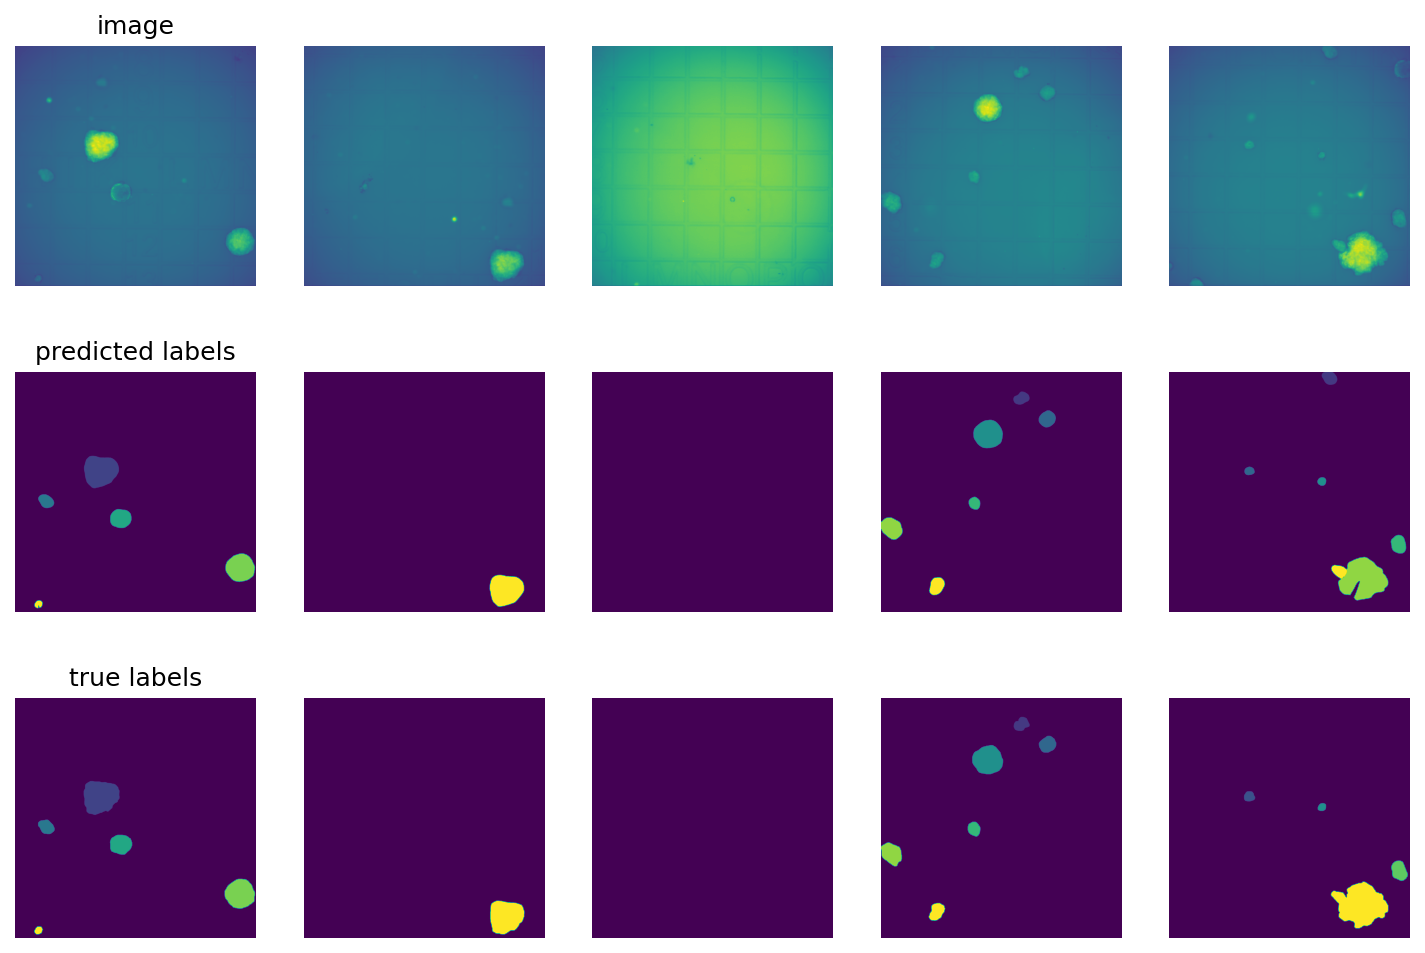

In [68]:
show_tests = 5
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data[:show_tests]):
    img = im.copy()
    plt.subplot(3,show_tests, k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,show_tests , show_tests+ k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,show_tests, 2*show_tests+ k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
